# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

from tqdm.auto import tqdm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [8]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [9]:
df_reviews.dropna(inplace=True)

In [10]:
df_reviews.duplicated().sum()

0

## EDA

Let's check the number of movies and reviews over years.

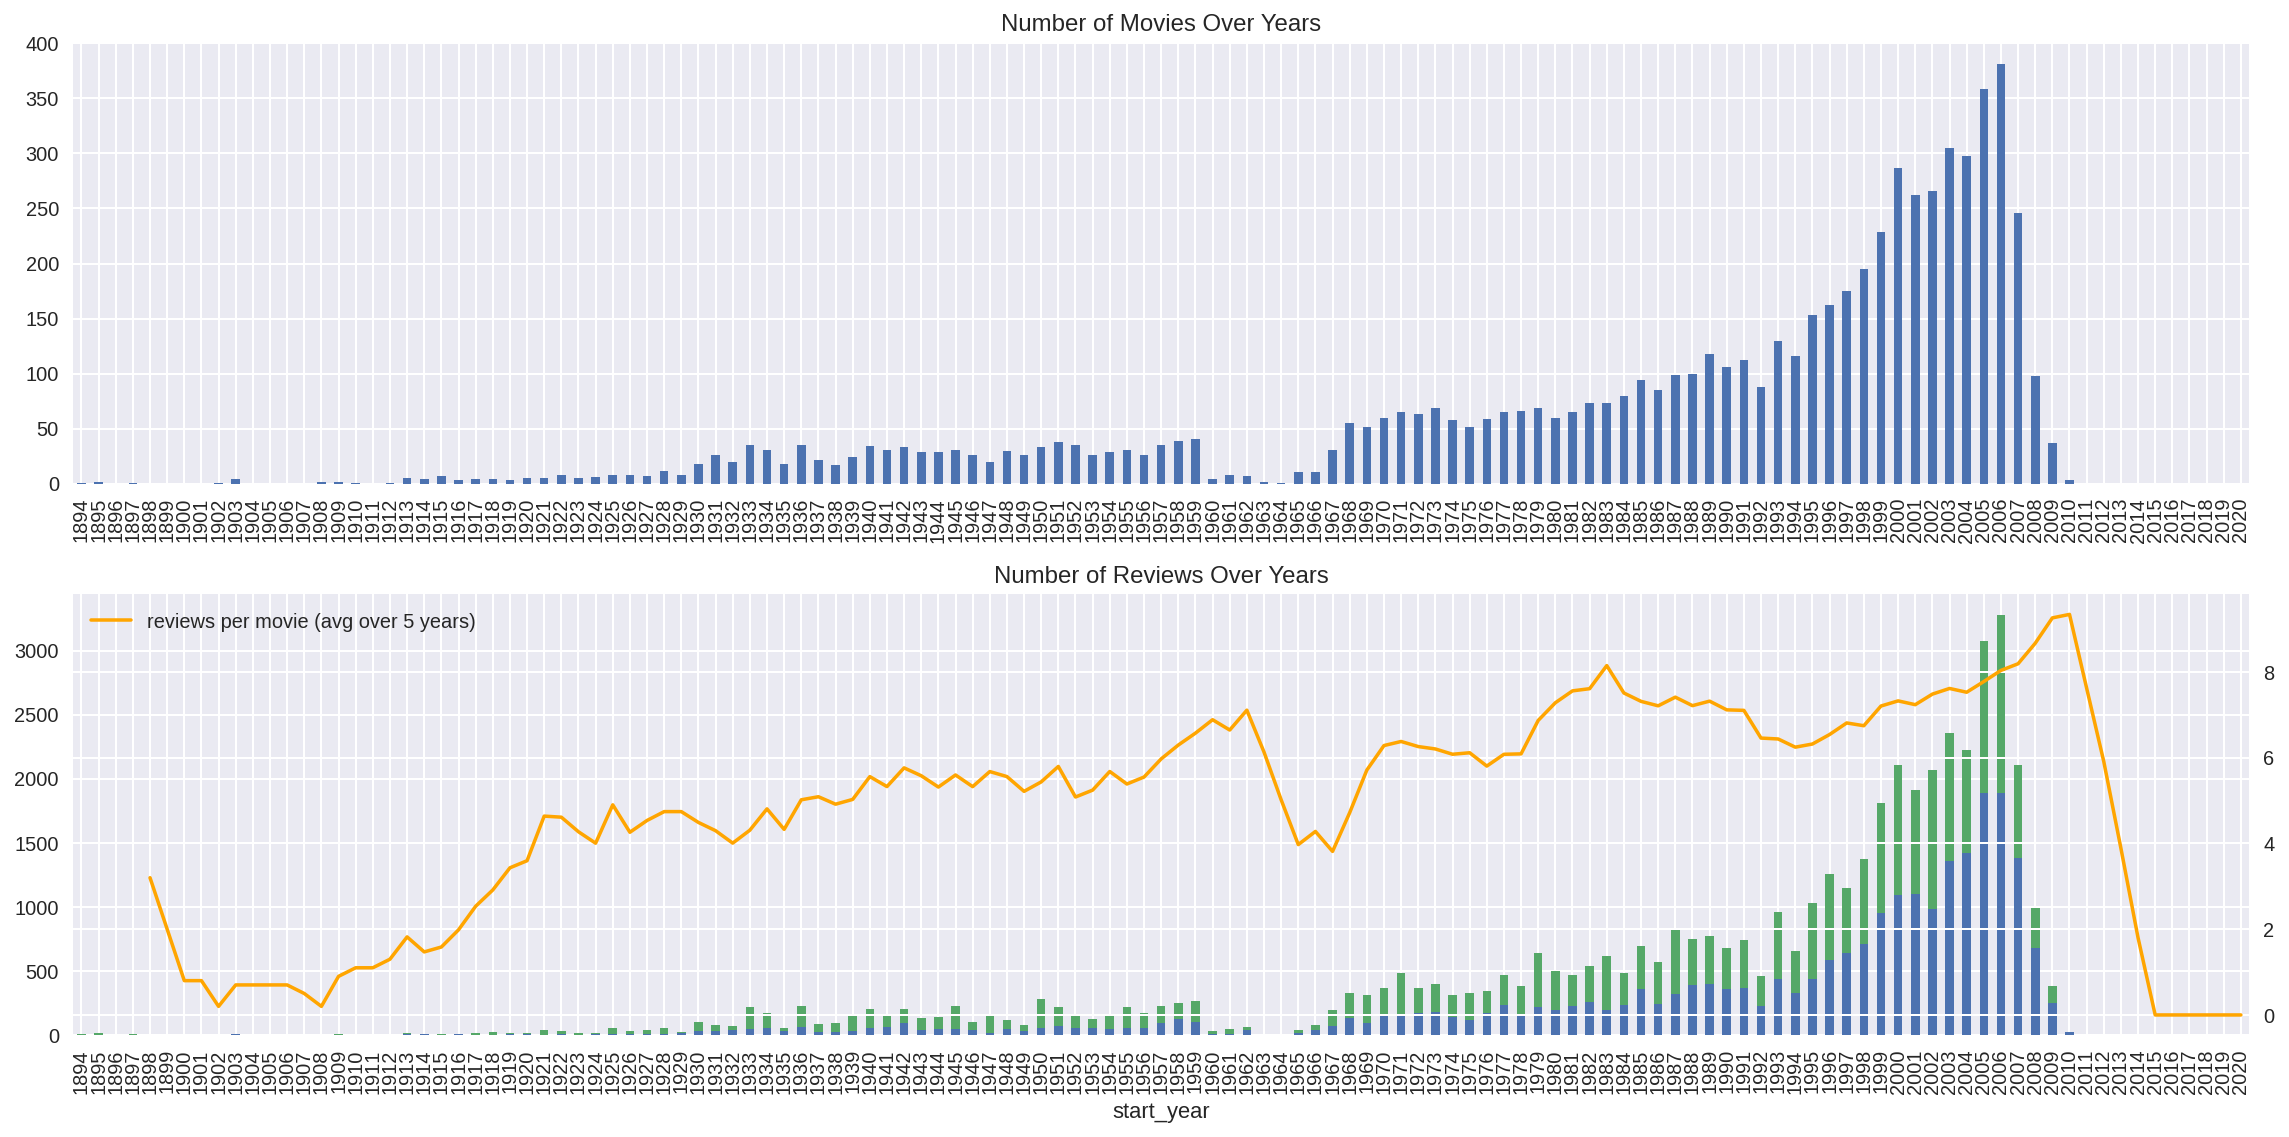

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

There's a positive proportional relationship between number of movies and number of reviews per year

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

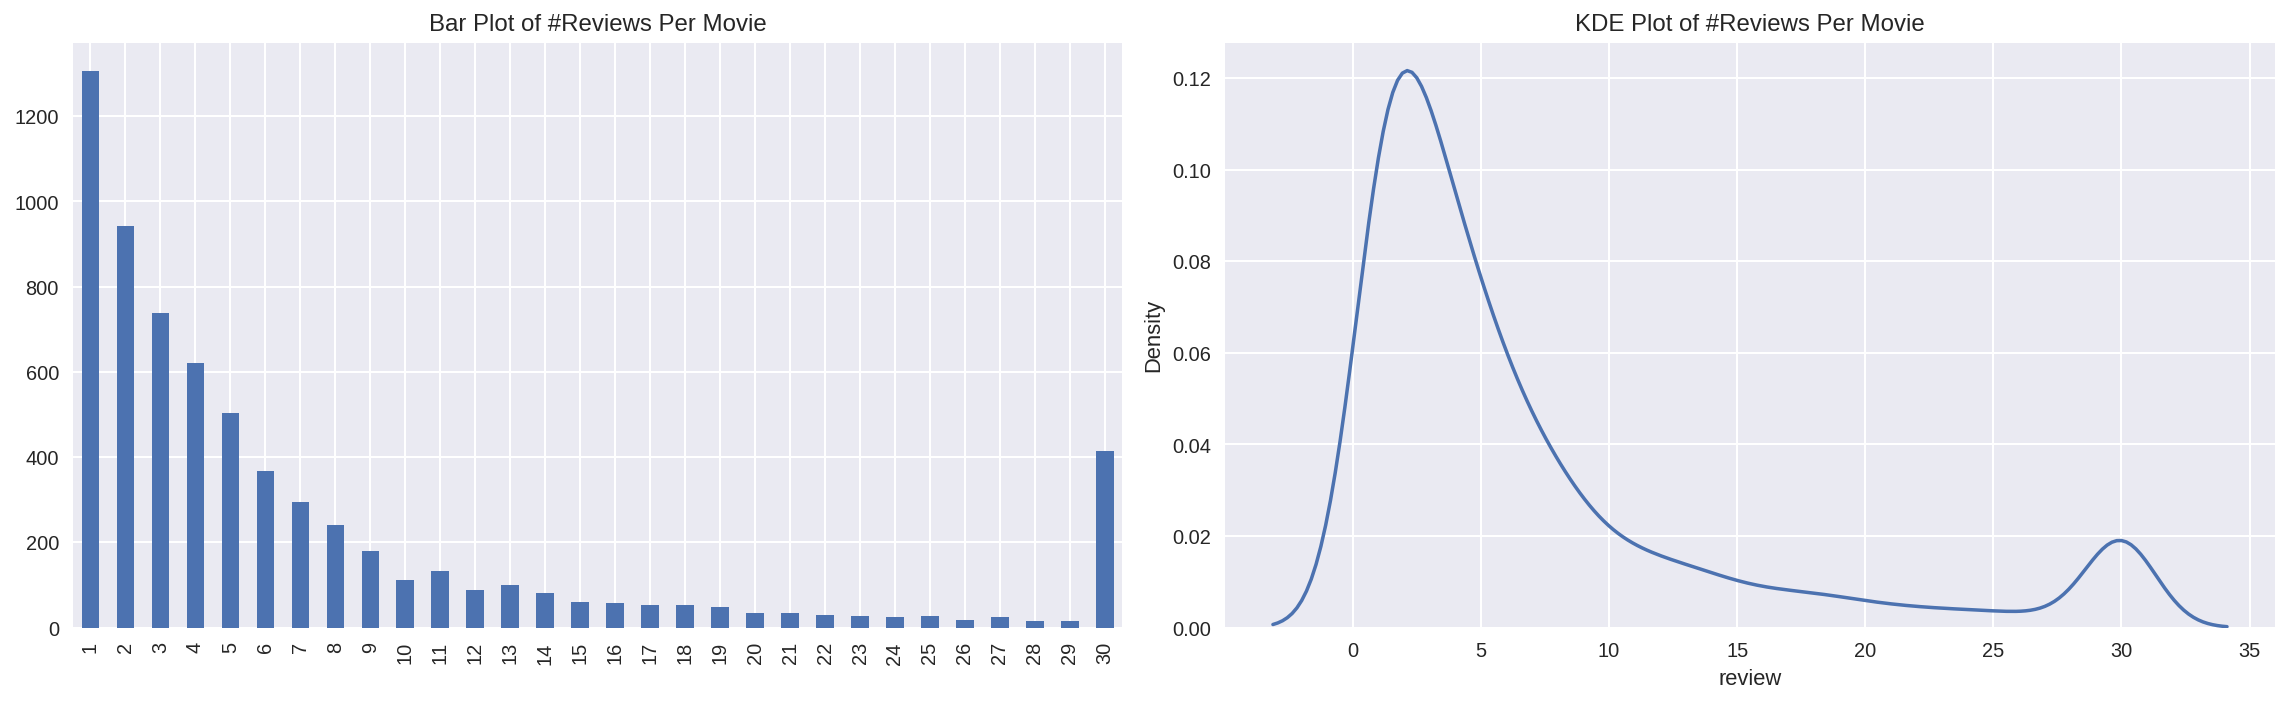

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

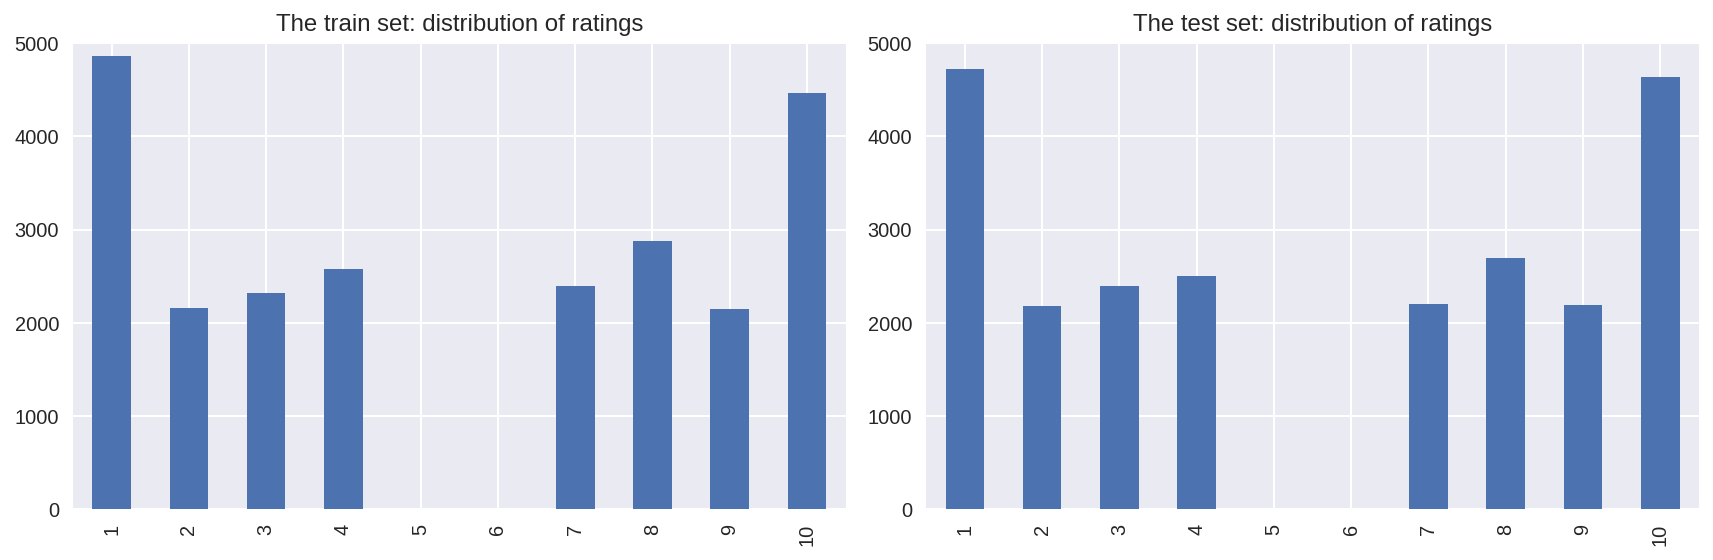

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Ratings are either really low or high. People don't tend to rate in the middle.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


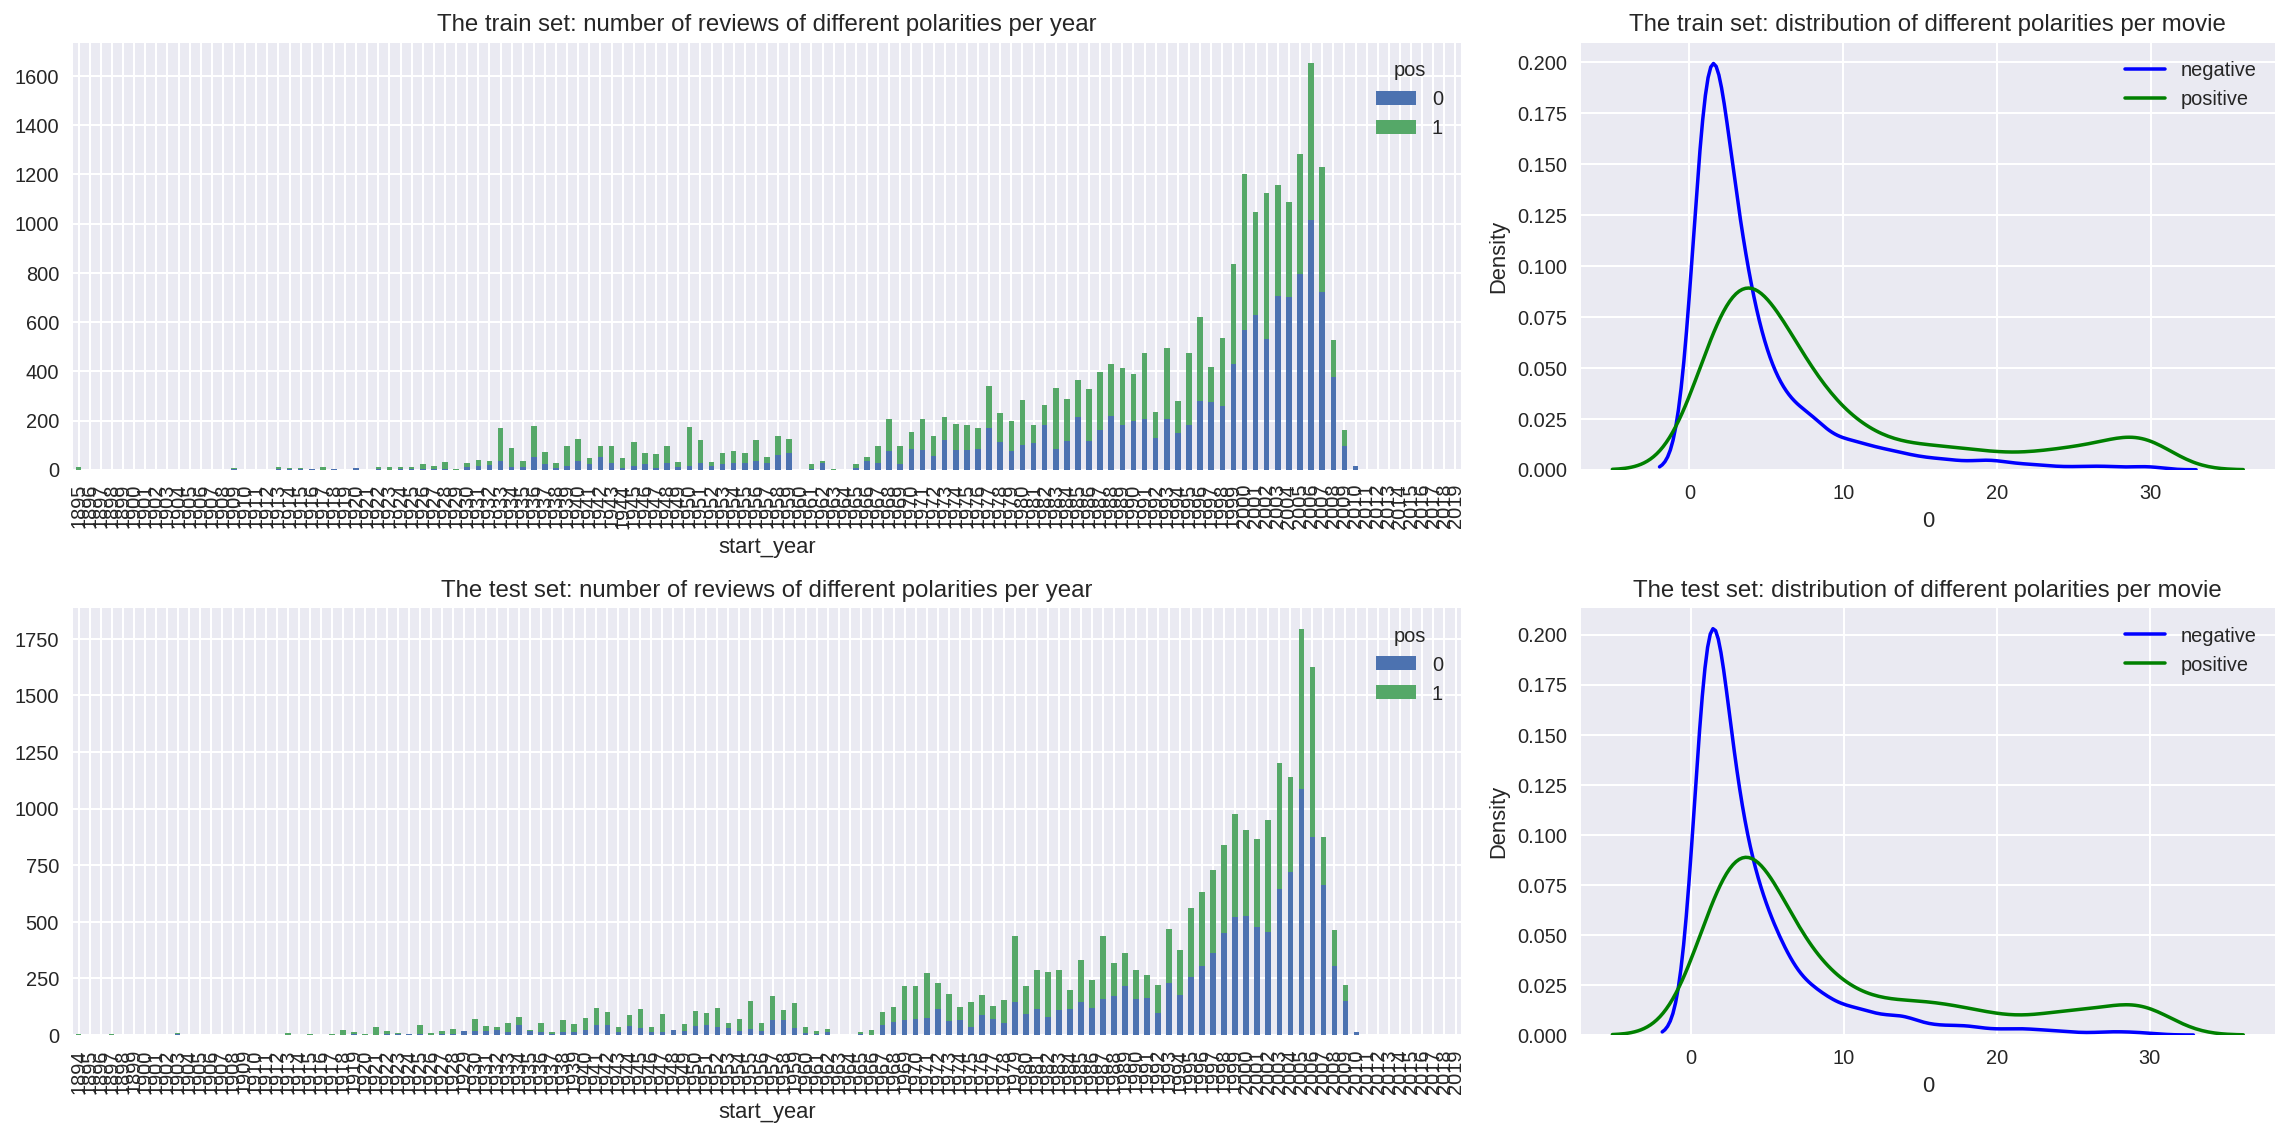

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Negative reviews start to dominate after 2000s. 

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [47]:
def normalization(text):
    lower_string = text.lower()
    no_number_string = re.sub(r'\d+','',lower_string)
    no_punc_string = re.sub(r'[^\w\s]','', no_number_string)

    return no_punc_string

In [48]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalization)

In [19]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there is no real story the film seems more lik...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teens in sin...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,im totally agree with garryjohal from singapor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038,this is another of my favorite columbos it spo...
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989,talk about being boring i got this expecting a...
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163,i never thought id say this about a biopic but...
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164,spirit and chaos is an artistic biopic of miya...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [49]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

In [50]:
corpus_train = df_reviews_train['review_norm']

In [51]:
corpus_test = df_reviews_test['review_norm']

### Model 0 - Constant

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
model_0 = DummyClassifier(random_state=42)

In [61]:
model_0.fit(corpus_train, train_target)

DummyClassifier(random_state=42)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


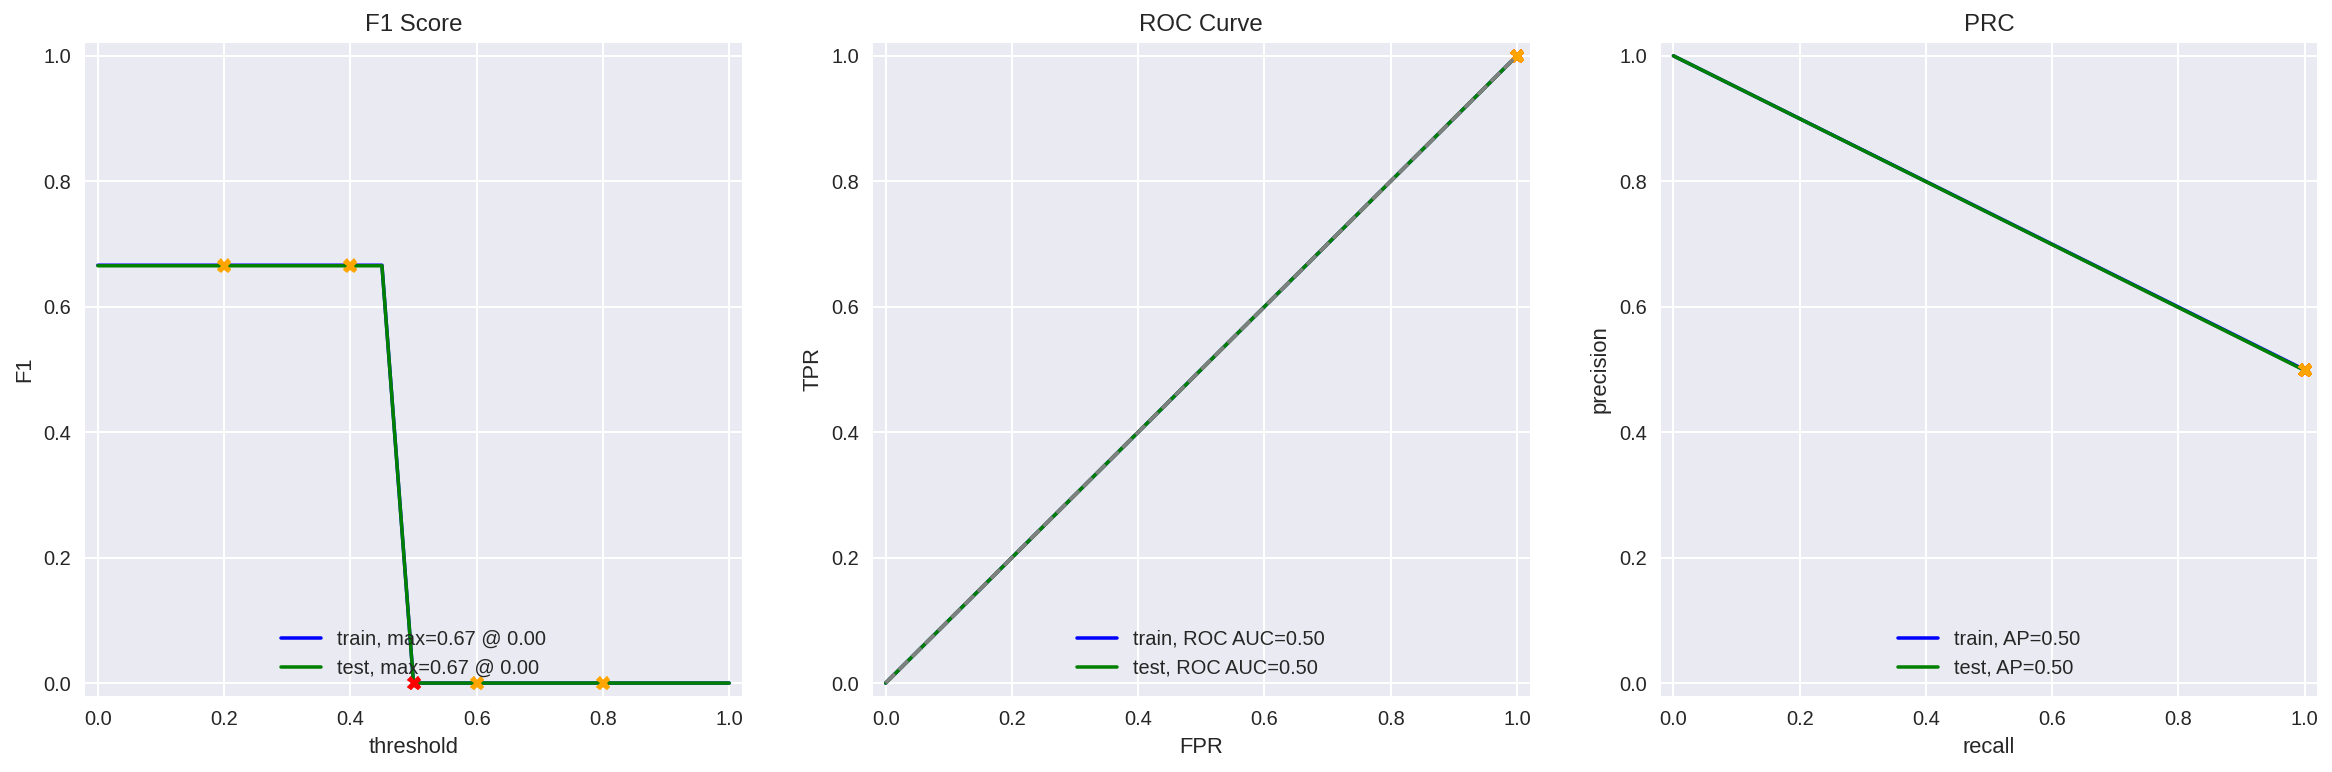

In [63]:
evaluate_model(model_0, corpus_train, train_target, corpus_test, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [66]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [67]:
stop_words = set(stopwords.words('english'))
count = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count.fit_transform(corpus_train)

In [68]:
model_1 = LogisticRegression(random_state=42, solver='liblinear')

In [69]:
model_1.fit(tf_idf_train, train_target)

LogisticRegression(random_state=42, solver='liblinear')

In [70]:
tf_idf_test = count.transform(corpus_test)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


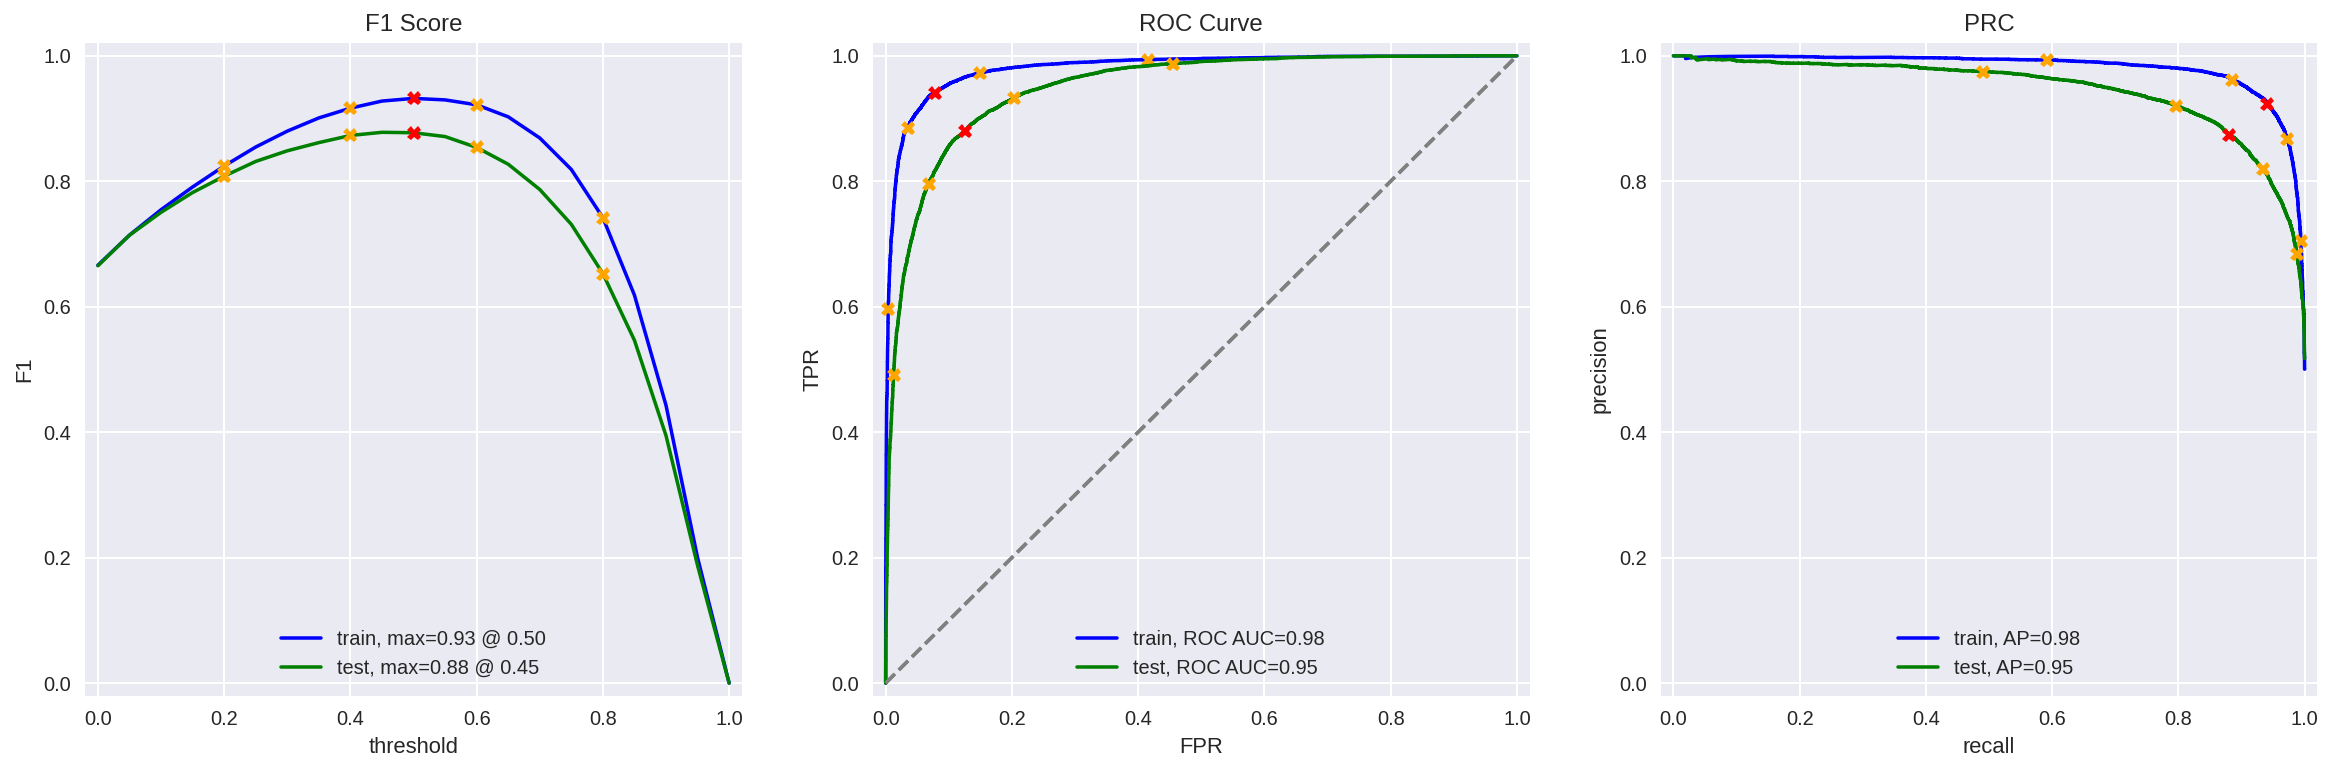

In [71]:
evaluate_model(model_1, tf_idf_train, train_target, tf_idf_test, test_target)

### Model 2 - spaCy, TF-IDF and LR

In [72]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [73]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return " ".join(lemmas)

In [75]:
corpus_train_lem = df_reviews_train['review_norm'].apply(lemmatize)

In [76]:
corpus_test_lem = df_reviews_test['review_norm'].apply(lemmatize)

In [77]:
model_2 = LogisticRegression(random_state=42, solver='liblinear')

In [78]:
stop_words = set(stopwords.words('english'))
count_2 = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_2.fit_transform(corpus_train_lem)

In [79]:
model_2.fit(tf_idf_train, train_target)

LogisticRegression(random_state=42, solver='liblinear')

In [80]:
tf_idf_test = count_2.transform(corpus_test_lem)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


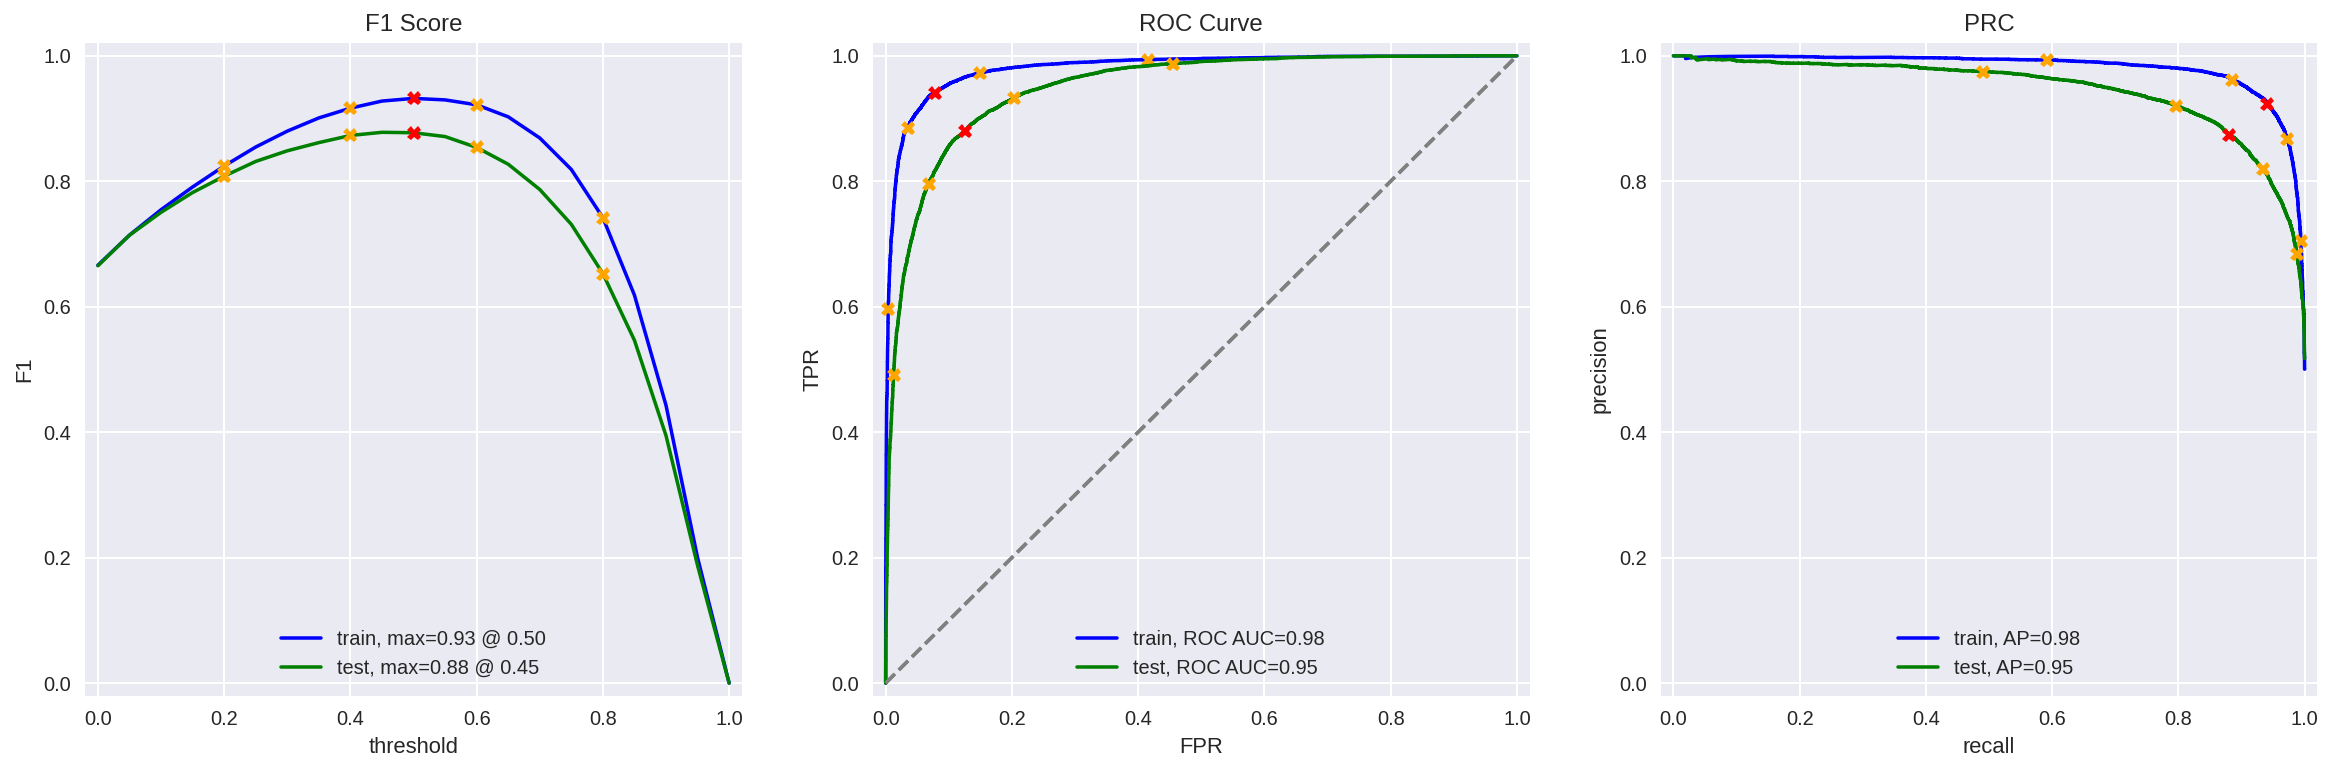

In [81]:
evaluate_model(model_2, tf_idf_train, train_target, tf_idf_test, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [82]:
from lightgbm import LGBMClassifier

In [83]:
model_3 = LGBMClassifier(random_state=42)

In [84]:
stop_words = set(stopwords.words('english'))
count_3 = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_3.fit_transform(corpus_train)

In [85]:
model_3.fit(tf_idf_train, train_target)

LGBMClassifier(random_state=42)

In [86]:
tf_idf_test = count_3.transform(corpus_test)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


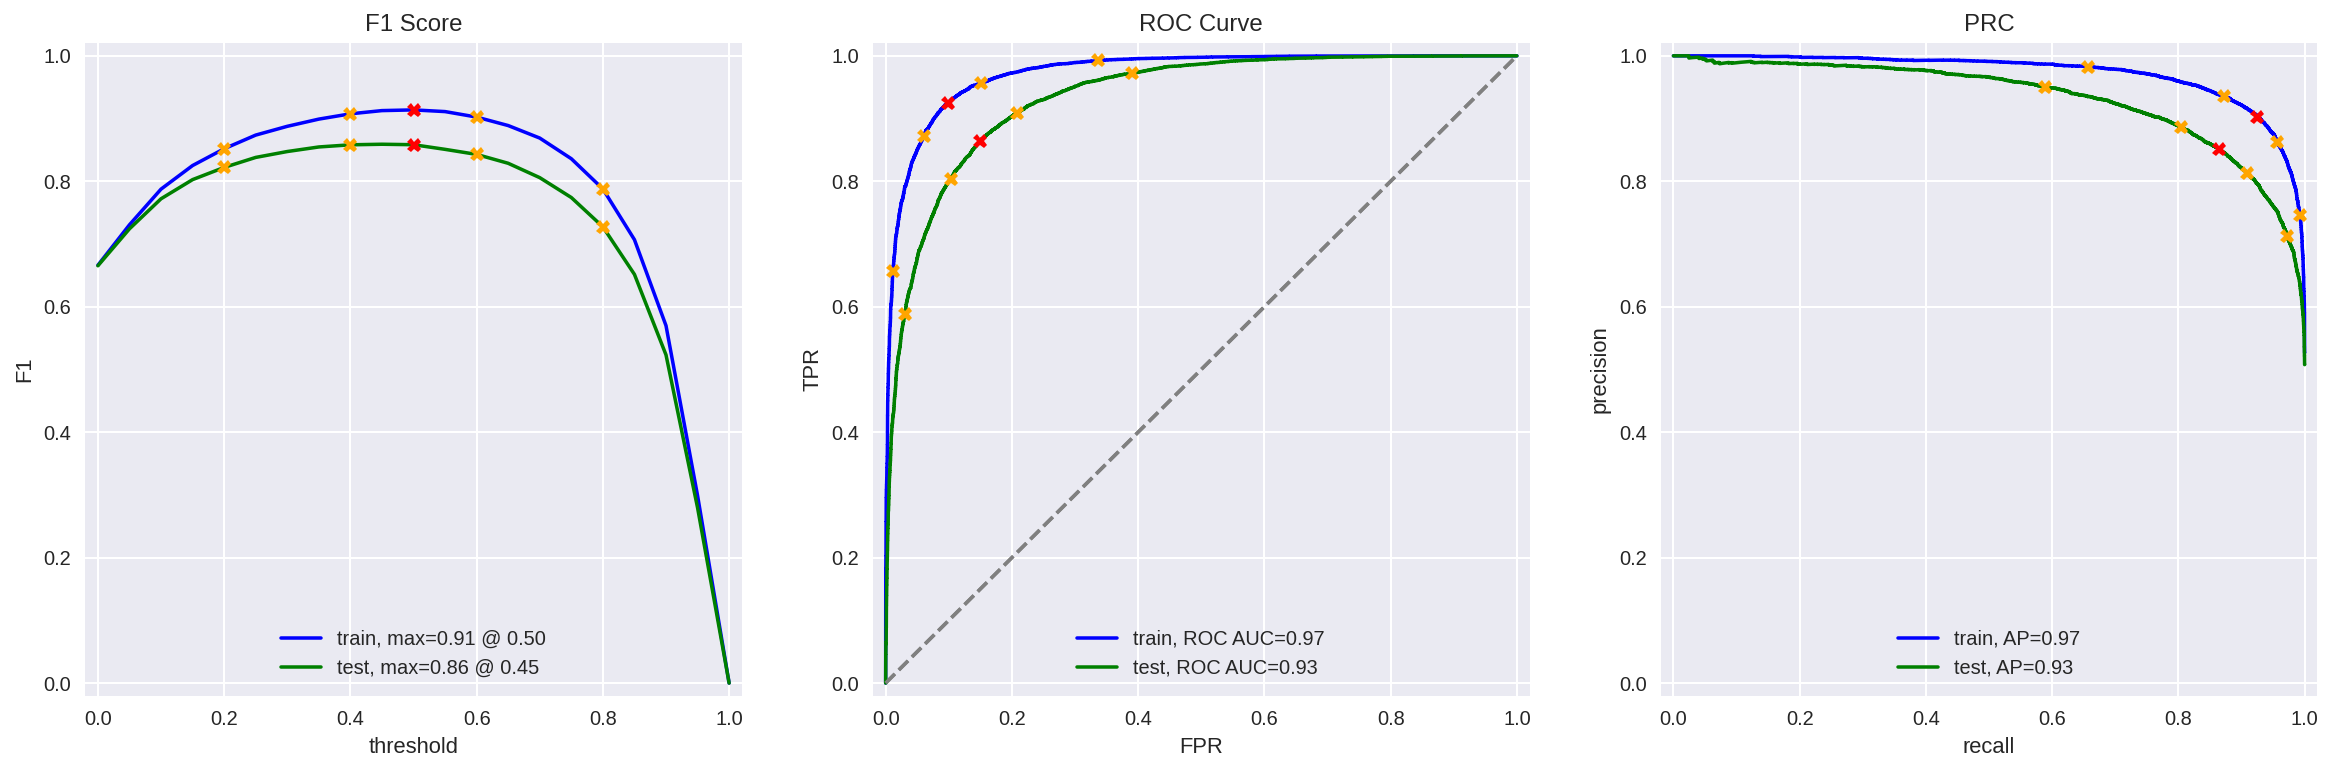

In [87]:
evaluate_model(model_3, tf_idf_train, train_target, tf_idf_test, test_target)

###  Model 4 - Desicion Tree

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
model_4 = RandomForestClassifier(random_state=42, max_depth=16)

In [90]:
model_4.fit(tf_idf_train, train_target)

RandomForestClassifier(max_depth=16, random_state=42)

In [91]:
tf_idf_test = count_3.transform(corpus_test)

          train  test
Accuracy   0.90  0.83
F1         0.90  0.83
APS        0.97  0.90
ROC AUC    0.97  0.91


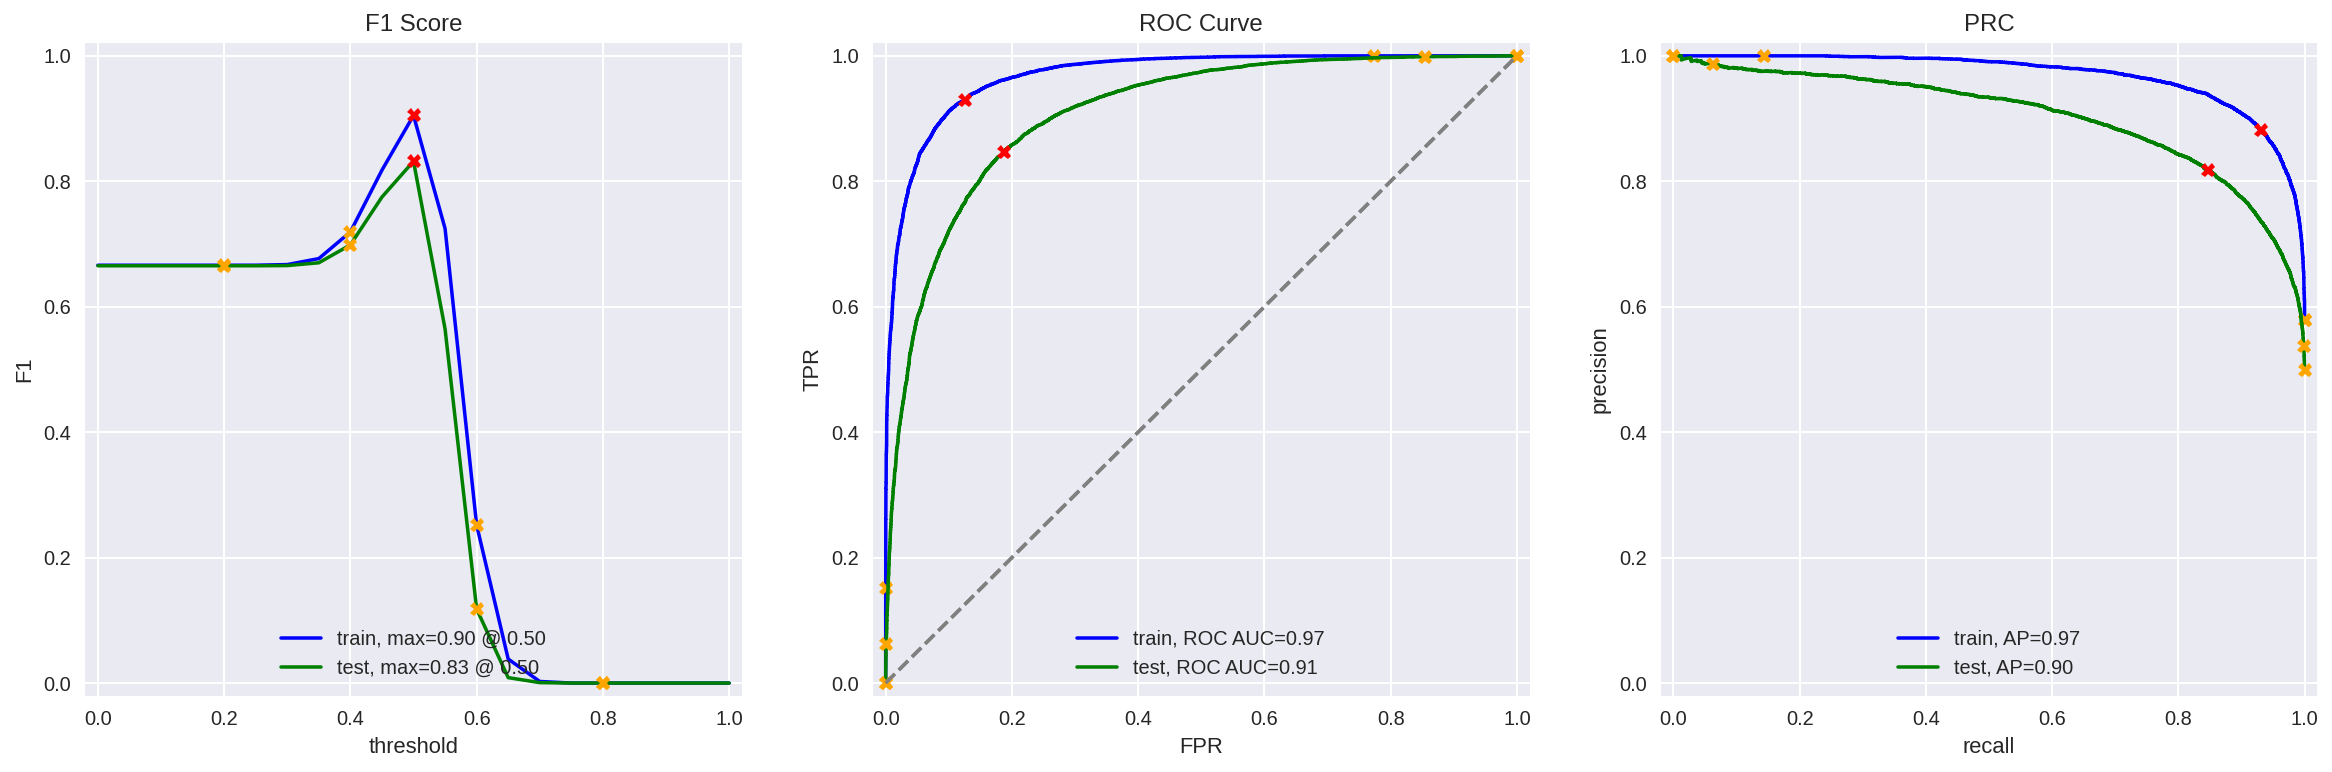

In [92]:
evaluate_model(model_4, tf_idf_train, train_target, tf_idf_test, test_target)

## My Reviews

In [93]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalization)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 1

In [94]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.13:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.33:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.47:  i didnt expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 2

In [95]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_2.transform(texts.apply(lambda x: lemmatize(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.13:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didnt expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [96]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_3.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  i did not simply like it not my kind of movie
0.36:  well i was bored and felt asleep in the middle of the movie
0.62:  i was really fascinated with the movie
0.50:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.69:  i didnt expect the reboot to be so good writers really cared about the source material
0.65:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.26:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 4

In [97]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(count_3.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  i did not simply like it not my kind of movie
0.52:  well i was bored and felt asleep in the middle of the movie
0.53:  i was really fascinated with the movie
0.52:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.54:  i didnt expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.50:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.56:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusions

The dataset was loaded and preprocessed. During analysis, it was found that there's a positive proportional relationship between number of movies and number of reviews per year. Negative reviews started to get ahead of positive reviews since 2000s. Ratings are either really low or high. People don't tend to rate in the middle. 4 models were trained and tested. All scores have been found to be at least 0.85